<a href="https://colab.research.google.com/github/MARUTHI-VARA-PRASAD/3d-Solar-System-/blob/main/Transfer_Learning_for_Waste_Classification_and_Reinforcement_Learning_for_Sustainable_Resource%C2%A0Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ===========================
# 0. Install & Imports
# ===========================
# (TensorFlow is usually preinstalled on Colab; pinned version optional)
!pip install -q scikit-learn matplotlib seaborn plotly pillow
import tensorflow as tf
print("TF version:", tf.__version__)


import os, zipfile
from google.colab import files
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("TF", tf.__version__)


TF version: 2.19.0
TF 2.19.0


In [ ]:
# ===========================
# 1. Upload & Extract your ZIP
# ===========================
print("Upload your ZIP file (e.g., waste_dataset.zip).")
uploaded = files.upload()  # choose your zip
zip_name = list(uploaded.keys())[0]
print("Uploaded:", zip_name)

extract_dir = '/content/dataset'
os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(zip_name, 'r') as z:
    z.extractall(extract_dir)

# Show top-level
print("Top-level contents:", os.listdir(extract_dir))


Upload your ZIP file (e.g., waste_dataset.zip).


Saving Garbage classification.zip to Garbage classification.zip
Uploaded: Garbage classification.zip
Top-level contents: ['Garbage classification']


In [ ]:
# ===========================
# 2. Auto-detect dataset folder containing classes
#    We search for a directory that contains at least these class names
# ===========================
expected_classes = set(['trash','plastic','paper','metal','glass','cardboard'])
found = None

for root, dirs, files in os.walk(extract_dir):
    dirnames = set(dirs)
    # lower-case names to be safe
    if expected_classes.issubset({d.lower() for d in dirs}):
        found = root
        break

if found is None:
    # fallback: check one extra nested folder with identical name (common zip behavior)
    # try depth 2
    for top in os.listdir(extract_dir):
        top_path = os.path.join(extract_dir, top)
        if os.path.isdir(top_path):
            for second in os.listdir(top_path):
                second_path = os.path.join(top_path, second)
                if os.path.isdir(second_path):
                    if expected_classes.issubset({d.lower() for d in os.listdir(second_path)}):
                        found = second_path
                        break
            if found: break

if found is None:
    print("WARNING: couldn't auto-detect folder with expected classes. Please inspect /content/dataset and set DATA_DIR manually.")
    print("Contents:", list(os.walk(extract_dir))[:2])
else:
    DATA_DIR = found
    print("Detected DATA_DIR:", DATA_DIR)
    print("Classes inside:", sorted(os.listdir(DATA_DIR)))


Detected DATA_DIR: /content/dataset/Garbage classification/Garbage classification
Classes inside: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [ ]:
# ===========================
# 3. Quick sanity checks / count images per class
# ===========================
if 'DATA_DIR' in globals():
    counts = {}
    for cl in sorted(os.listdir(DATA_DIR)):
        cl_path = os.path.join(DATA_DIR, cl)
        if os.path.isdir(cl_path):
            files_list = [f for f in os.listdir(cl_path) if os.path.isfile(os.path.join(cl_path, f))]
            counts[cl] = len(files_list)
    df_counts = pd.DataFrame.from_dict(counts, orient='index', columns=['count']).sort_values('count', ascending=False)
    display(df_counts)
else:
    raise SystemExit("DATA_DIR not found. Fix path and re-run.")


,count
paper,594
glass,501
plastic,482
metal,410
cardboard,403
trash,137


In [ ]:
# ===========================
# 4. Load dataset with tf.data
# ===========================
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

train_ds = image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
val_ds = image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
NUM_CLASSES = len(class_names)
print("Classes:", class_names)


Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [ ]:
# ===========================
# 5. Prefetch, augmentation
# ===========================
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.08),
])


In [ ]:
# ===========================
# 6. Build the ResNet50 transfer-learning model
# ===========================
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base_model.trainable = False  # start with frozen base

inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = data_augmentation(inputs)
x = preprocess_input(x)   # ResNet-specific preprocessing
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 6)         │     12,294 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,600,006 (90.03 MB)

 Trainable params: 12,294 (48.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# ===========================
# 7. Train the head
# ===========================
EPOCHS_HEAD = 8
history_head = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_HEAD)


Epoch 1/8
64/64 ━━━━━━━━━━━━━━━━━━━━ 587s 9s/step - accuracy: 0.7894 - loss: 0.6171 - val_accuracy: 0.8218 - val_loss: 0.5549
Epoch 2/8
64/64 ━━━━━━━━━━━━━━━━━━━━ 575s 9s/step - accuracy: 0.7829 - loss: 0.5853 - val_accuracy: 0.8218 - val_loss: 0.5345
Epoch 3/8
64/64 ━━━━━━━━━━━━━━━━━━━━ 543s 9s/step - accuracy: 0.7867 - loss: 0.5994 - val_accuracy: 0.8178 - val_loss: 0.5186
Epoch 4/8
64/64 ━━━━━━━━━━━━━━━━━━━━ 578s 9s/step - accuracy: 0.8147 - loss: 0.5306 - val_accuracy: 0.8257 - val_loss: 0.5065
Epoch 5/8
64/64 ━━━━━━━━━━━━━━━━━━━━ 574s 9s/step - accuracy: 0.8206 - loss: 0.5041 - val_accuracy: 0.8317 - val_loss: 0.4863
Epoch 6/8
64/64 ━━━━━━━━━━━━━━━━━━━━ 576s 9s/step - accuracy: 0.8339 - loss: 0.4993 - val_accuracy: 0.8337 - val_loss: 0.4828
Epoch 7/8
64/64 ━━━━━━━━━━━━━━━━━━━━ 576s 9s/step - accuracy: 0.8296 - loss: 0.4659 - val_accuracy: 0.8455 - val_loss: 0.4726
Epoch 8/8
64/64 ━━━━━━━━━━━━━━━━━━━━ 574s 9s/step - accuracy: 0.8502 - loss: 0.4355 - val_accuracy: 0.8495 - val_loss:

In [ ]:
# ===========================
# 8. Fine-tuning: unfreeze top layers and train lower LR
# ===========================
# Unfreeze last ~50 layers (tune based on your dataset size)
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

EPOCHS_FINE = 6
history_fine = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_FINE)


Epoch 1/6
64/64 ━━━━━━━━━━━━━━━━━━━━ 893s 14s/step - accuracy: 0.7618 - loss: 0.6557 - val_accuracy: 0.8297 - val_loss: 0.4549
Epoch 2/6
64/64 ━━━━━━━━━━━━━━━━━━━━ 969s 14s/step - accuracy: 0.8566 - loss: 0.4207 - val_accuracy: 0.8673 - val_loss: 0.4083
Epoch 3/6
64/64 ━━━━━━━━━━━━━━━━━━━━ 877s 14s/step - accuracy: 0.8888 - loss: 0.3394 - val_accuracy: 0.8851 - val_loss: 0.3777
Epoch 4/6
64/64 ━━━━━━━━━━━━━━━━━━━━ 964s 14s/step - accuracy: 0.9102 - loss: 0.2999 - val_accuracy: 0.8891 - val_loss: 0.3629
Epoch 5/6
64/64 ━━━━━━━━━━━━━━━━━━━━ 918s 14s/step - accuracy: 0.9232 - loss: 0.2519 - val_accuracy: 0.8851 - val_loss: 0.3595
Epoch 6/6
64/64 ━━━━━━━━━━━━━━━━━━━━ 889s 14s/step - accuracy: 0.9308 - loss: 0.2276 - val_accuracy: 0.8931 - val_loss: 0.3432


Head training:


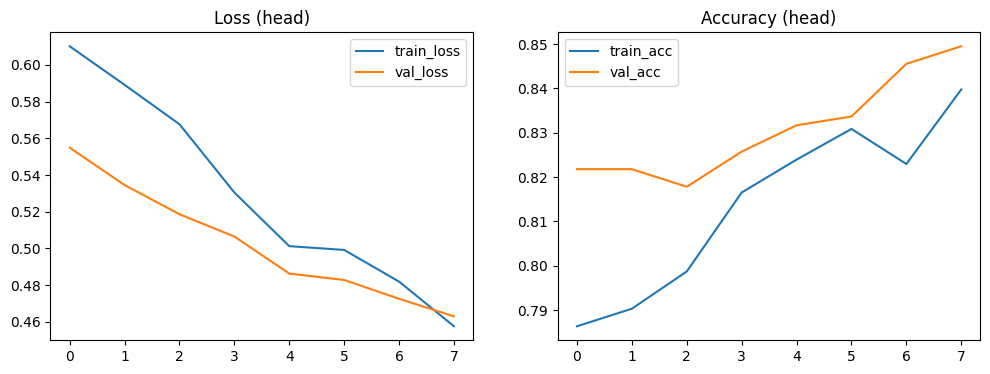

Fine-tune:


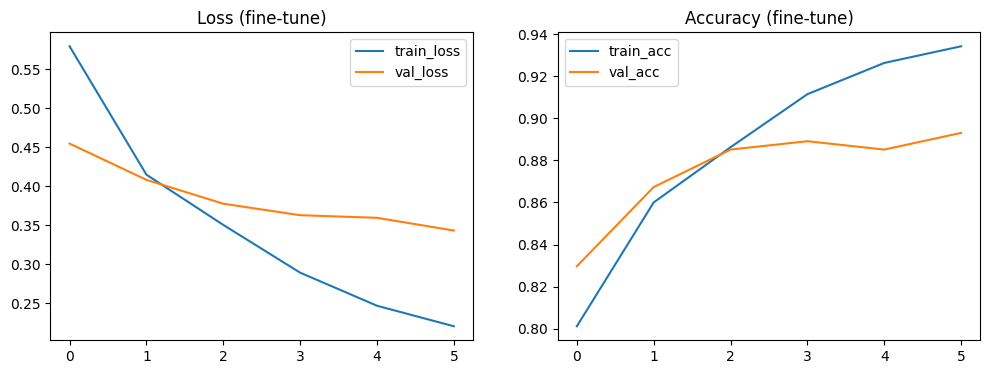

In [ ]:
# ===========================
# 9. Plot training curves (head + fine-tune)
# ===========================
def plot_hist(h, title=''):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(h.history['loss'], label='train_loss')
    if 'val_loss' in h.history:
        plt.plot(h.history['val_loss'], label='val_loss')
    plt.title('Loss '+title); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(h.history['accuracy'], label='train_acc')
    if 'val_accuracy' in h.history:
        plt.plot(h.history['val_accuracy'], label='val_acc')
    plt.title('Accuracy '+title); plt.legend()
    plt.show()

print("Head training:")
plot_hist(history_head, '(head)')
print("Fine-tune:")
plot_hist(history_fine, '(fine-tune)')


16/16 ━━━━━━━━━━━━━━━━━━━━ 118s 7s/step
Classification Report:
              precision    recall  f1-score   support

   cardboard       0.93      0.96      0.94        69
       glass       0.89      0.91      0.90       102
       metal       0.82      0.94      0.88        88
       paper       0.94      0.93      0.94       123
     plastic       0.91      0.80      0.85        89
       trash       0.82      0.68      0.74        34

    accuracy                           0.89       505
   macro avg       0.89      0.87      0.88       505
weighted avg       0.89      0.89      0.89       505



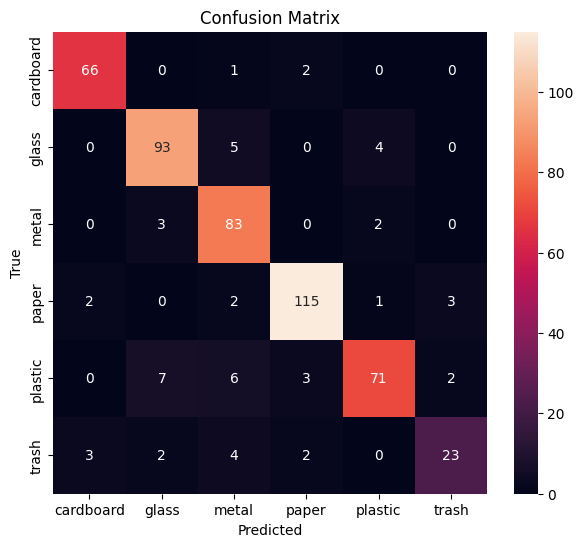

In [ ]:
# ===========================
# 10. Evaluate on validation set (predictions, classification report, confusion matrix)
# ===========================
# Collect all validation images & labels (may use memory; ok for moderate datasets)
val_images = []
val_labels = []
for batch_imgs, batch_labels in val_ds:
    val_images.append(batch_imgs.numpy())
    val_labels.append(batch_labels.numpy())
val_images = np.vstack(val_images)
val_labels = np.hstack(val_labels)

preds = model.predict(val_images, batch_size=32)
pred_classes = np.argmax(preds, axis=1)

print("Classification Report:")
print(classification_report(val_labels, pred_classes, target_names=class_names))

cm = confusion_matrix(val_labels, pred_classes)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
plt.show()


In [ ]:
import os

for root, dirs, files in os.walk("/content"):
    if any(name in root for name in ["Garbage", "garbage"]):
        print(root, "->", dirs[:6], len(files))


/content/dataset/Garbage classification -> ['Garbage classification'] 0
/content/dataset/Garbage classification/Garbage classification -> ['glass', 'plastic', 'cardboard', 'trash', 'paper', 'metal'] 0
/content/dataset/Garbage classification/Garbage classification/glass -> [] 501
/content/dataset/Garbage classification/Garbage classification/plastic -> [] 482
/content/dataset/Garbage classification/Garbage classification/cardboard -> [] 403
/content/dataset/Garbage classification/Garbage classification/trash -> [] 137
/content/dataset/Garbage classification/Garbage classification/paper -> [] 594
/content/dataset/Garbage classification/Garbage classification/metal -> [] 410


In [ ]:
#Step 10.5
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_dir = "/content/dataset/Garbage classification/Garbage classification"

# Image data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,      # 80% train / 20% validation
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation generator
val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print("✅ Data generators created successfully!")
print("Classes:", train_generator.class_indices)



Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.
✅ Data generators created successfully!
Classes: {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 939ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning:

The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


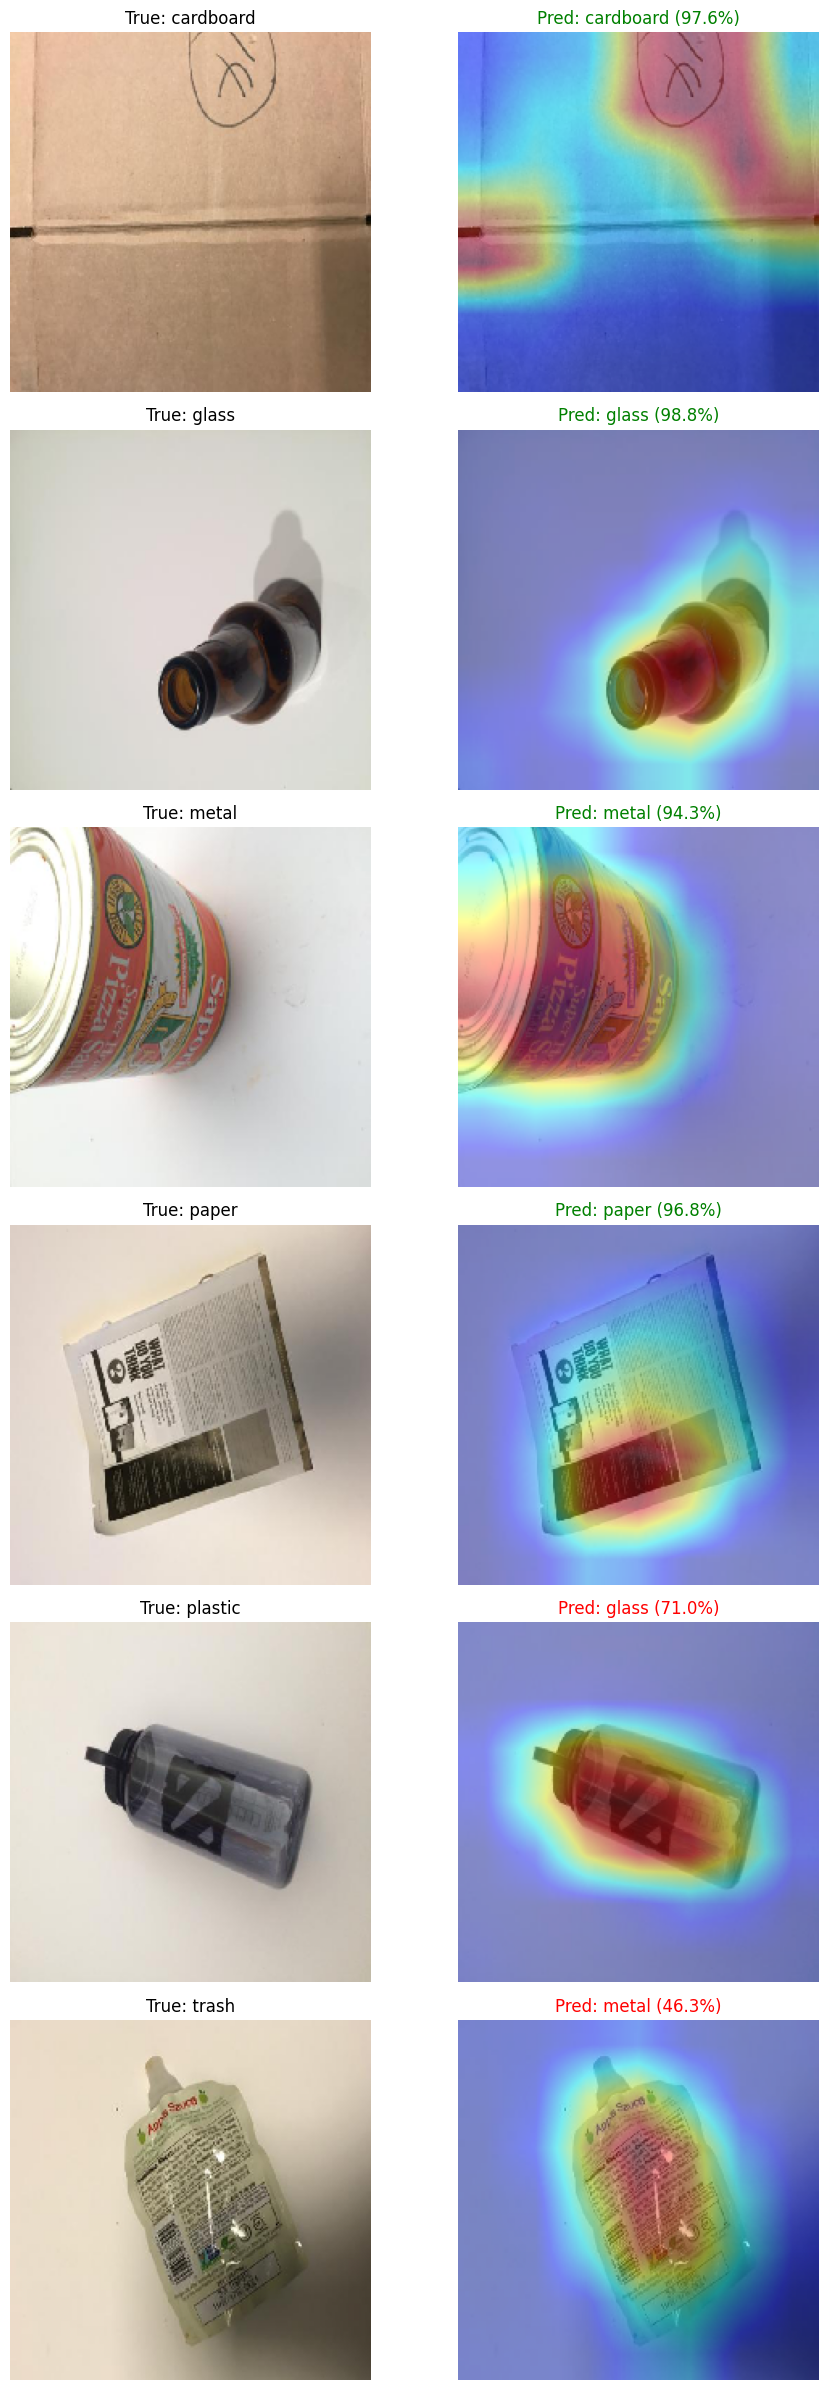

In [ ]:
# ===========================================================
# 11. Grad-CAM (explainability) - show one example per class
# ===========================================================
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing import image

# -------------------------
# Helper: Load & preprocess image
# -------------------------
def load_and_preprocess(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
    return img_array, np.array(img)

# -------------------------
# Helper: Grad-CAM heatmap
# -------------------------
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    base_model = model.get_layer("resnet50")
    grad_model = tf.keras.models.Model(
        [base_model.input],
        [base_model.get_layer(last_conv_layer_name).output, base_model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# -------------------------
# Grad-CAM Visualization per class
# -------------------------
class_names = list(train_generator.class_indices.keys())
last_conv_layer_name = "conv5_block3_out"

fig, axes = plt.subplots(len(class_names), 2, figsize=(10, 4 * len(class_names)))

for idx, cls in enumerate(class_names):
    # Pick first image of this class from val_generator.filepaths
    for img_path in val_generator.filepaths:
        if f"/{cls}/" in img_path.replace("\\","/"):  # works for Windows or Linux paths
            img_array, orig_img = load_and_preprocess(img_path)
            orig_img = (orig_img).astype('uint8')
            break

    # Predict
    preds = model.predict(img_array)
    pred_idx = np.argmax(preds[0])
    pred_label = class_names[pred_idx]
    confidence = float(preds[0][pred_idx]) * 100

    # Grad-CAM heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=pred_idx)

    # Overlay heatmap
    heatmap = cv2.resize(heatmap, (orig_img.shape[1], orig_img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(orig_img, 0.6, heatmap, 0.4, 0)

    # Plot
    correct = pred_label == cls
    color = "green" if correct else "red"

    axes[idx, 0].imshow(orig_img)
    axes[idx, 0].axis("off")
    axes[idx, 0].set_title(f"True: {cls}", color="black", fontsize=12)

    axes[idx, 1].imshow(superimposed_img[..., ::-1])
    axes[idx, 1].axis("off")
    axes[idx, 1].set_title(f"Pred: {pred_label} ({confidence:.1f}%)", color=color, fontsize=12)

plt.tight_layout()
plt.show()



In [ ]:
# ===========================
# 12. Predictive Analytics: Save a small dashboard snapshot & class distribution
# ===========================
import pandas as pd
import plotly.express as px

# Count number of images per class using train_generator
class_counts = {cls: 0 for cls in train_generator.class_indices.keys()}

for img_path in train_generator.filepaths:
    for cls in class_counts.keys():
        if f"/{cls}/" in img_path.replace("\\","/"):
            class_counts[cls] += 1
            break

# Convert to DataFrame
df_counts = pd.DataFrame(list(class_counts.items()), columns=['class', 'count'])

# Plot bar chart
fig = px.bar(df_counts, x='class', y='count', title='Class distribution of dataset',
             text='count', color='class')
fig.show()


In [ ]:
# Save model in native Keras format
model_save_path = "/content/waste_resnet50_model.keras"
model.save(model_save_path)
print("✅ Saved model to:", model_save_path)


✅ Saved model to: /content/waste_resnet50_model.keras


In [ ]:
from tensorflow.keras.models import load_model

loaded_model = load_model("/content/waste_resnet50_model.keras")  # or .h5


✅ Model loaded from: /content/waste_resnet50_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning:

The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


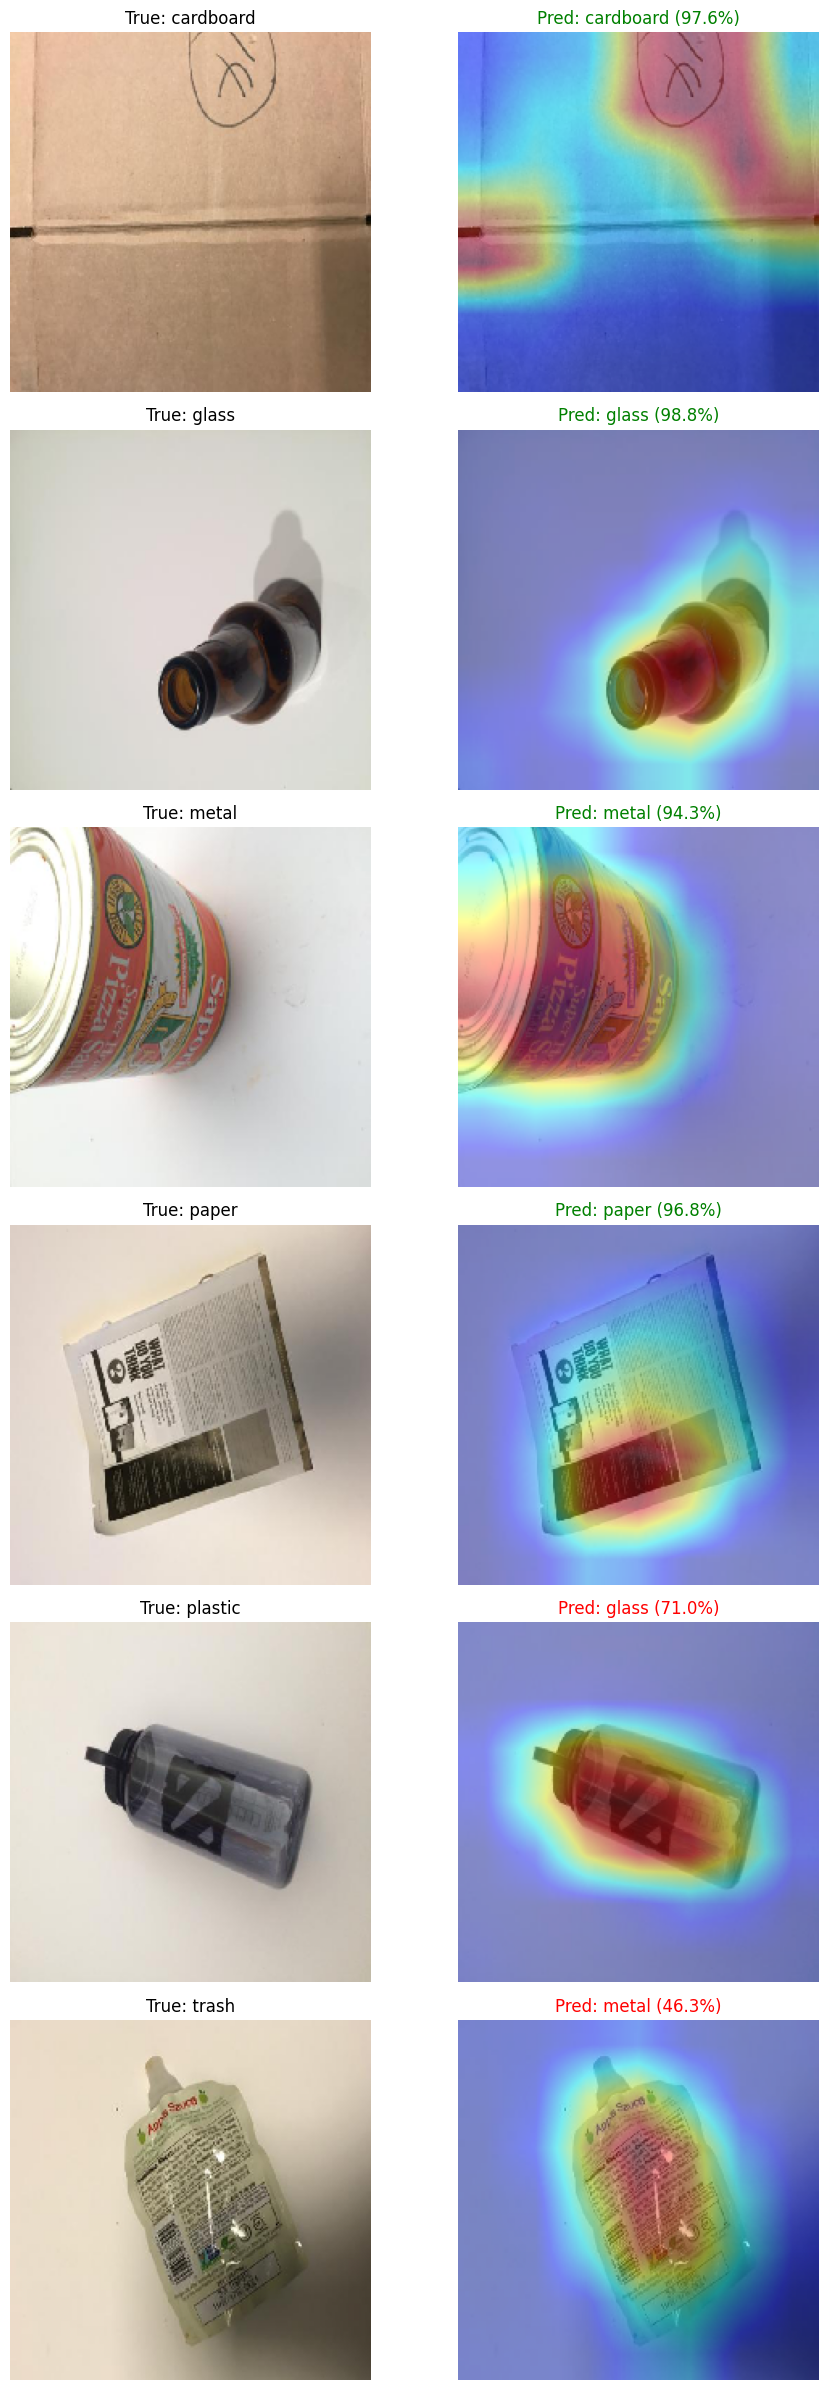

In [ ]:
# ===========================
# 13. Save the trained model
# ===========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# -------------------------
# Load trained model
# -------------------------
model_path = "/content/waste_resnet50_model.keras"
model = load_model(model_path)
print("✅ Model loaded from:", model_path)

# -------------------------
# Prepare class info
# -------------------------
class_names = list(train_generator.class_indices.keys())
last_conv_layer_name = "conv5_block3_out"

# -------------------------
# Compute per-class accuracy on validation set
# -------------------------
true_labels = []
pred_labels = []

for img_path, lbl in zip(val_generator.filepaths, val_generator.classes):
    img_array, _ = load_and_preprocess(img_path)
    preds = model.predict(img_array)
    pred_idx = np.argmax(preds[0])

    true_labels.append(lbl)
    pred_labels.append(pred_idx)

df_metrics = pd.DataFrame({
    'true': true_labels,
    'pred': pred_labels
})
df_metrics['true_label'] = df_metrics['true'].apply(lambda x: class_names[x])
df_metrics['pred_label'] = df_metrics['pred'].apply(lambda x: class_names[x])
df_metrics['correct'] = df_metrics['true_label'] == df_metrics['pred_label']

# Accuracy per class
accuracy_per_class = df_metrics.groupby('true_label')['correct'].mean().reset_index()
accuracy_per_class['accuracy'] = accuracy_per_class['correct']*100

# -------------------------
# Class distribution chart
# -------------------------
class_counts = {cls: 0 for cls in class_names}
for img_path in val_generator.filepaths:
    for cls in class_names:
        if f"/{cls}/" in img_path.replace("\\","/"):
            class_counts[cls] += 1
            break

df_counts = pd.DataFrame(list(class_counts.items()), columns=['class', 'count'])

# Plot with Plotly
fig = px.bar(df_counts, x='class', y='count', title='Validation Set Class Distribution',
             text='count', color='class')
fig.show()

# -------------------------
# Accuracy per class chart
# -------------------------
fig_acc = px.bar(accuracy_per_class, x='true_label', y='accuracy', title='Per-class Accuracy (%)',
                 text='accuracy', color='true_label')
fig_acc.show()

# -------------------------
# Grad-CAM for one image per class
# -------------------------
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    base_model = model.get_layer("resnet50")
    grad_model = tf.keras.models.Model(
        [base_model.input],
        [base_model.get_layer(last_conv_layer_name).output, base_model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap,0)/tf.math.reduce_max(heatmap)
    return heatmap.numpy()

fig, axes = plt.subplots(len(class_names), 2, figsize=(10, 4*len(class_names)))

for idx, cls in enumerate(class_names):
    # First image of this class in val set
    for img_path in val_generator.filepaths:
        if f"/{cls}/" in img_path.replace("\\","/"):
            img_array, orig_img = load_and_preprocess(img_path)
            orig_img = (orig_img).astype('uint8')
            break

    # Prediction
    preds = model.predict(img_array)
    pred_idx = np.argmax(preds[0])
    pred_label = class_names[pred_idx]
    confidence = float(preds[0][pred_idx])*100

    # Grad-CAM
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=pred_idx)
    heatmap = cv2.resize(heatmap, (orig_img.shape[1], orig_img.shape[0]))
    heatmap = np.uint8(255*heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(orig_img, 0.6, heatmap, 0.4, 0)

    # Plot
    correct = pred_label == cls
    color = "green" if correct else "red"
    axes[idx,0].imshow(orig_img)
    axes[idx,0].axis("off")
    axes[idx,0].set_title(f"True: {cls}", fontsize=12)
    axes[idx,1].imshow(superimposed_img[..., ::-1])
    axes[idx,1].axis("off")
    axes[idx,1].set_title(f"Pred: {pred_label} ({confidence:.1f}%)", color=color, fontsize=12)

plt.tight_layout()
plt.show()


In [ ]:
# ==========================================
# 14. Manual Image Prediction with Grad-CAM
# ==========================================
from google.colab import files
import os

# Define recyclable classes
recyclable_classes = ['glass', 'plastic', 'cardboard', 'paper', 'metal']

# Upload a single image
uploaded = files.upload()  # Colab file picker

for fname in uploaded.keys():
    img_path = os.path.join("/content", fname)

    # Preprocess image
    img_array, orig_img = load_and_preprocess(img_path)
    orig_img = orig_img.astype('uint8')

    # Predict
    preds = model.predict(img_array)
    pred_idx = np.argmax(preds[0])
    pred_label = class_names[pred_idx]
    confidence = float(preds[0][pred_idx]) * 100

    # Check if recyclable
    if pred_label in recyclable_classes:
        recycle_status = "♻️ Recyclable"
    else:
        recycle_status = "❌ Non-Recyclable"

    print(f"✅ Predicted Class: {pred_label}, Confidence: {confidence:.2f}% --> {recycle_status}")

    # Grad-CAM
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=pred_idx)
    heatmap = cv2.resize(heatmap, (orig_img.shape[1], orig_img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(orig_img, 0.6, heatmap, 0.4, 0)

    # Plot original + Grad-CAM
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(orig_img)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(superimposed_img[..., ::-1])
    plt.title(f"Grad-CAM: {pred_label} ({confidence:.1f}%)\n{recycle_status}")
    plt.axis("off")
    plt.show()


KeyboardInterrupt: 